## INITIALIZE: load trial info

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [77]:
with open("C:/Users/Sarah Zheng/dev/cards-deception/cards-game/src/assets/trials_40shuffled.json", "r") as read_file:
    trials_source = json.load(read_file)

In [ ]:
trials = pd.DataFrame(trials_source)

In [4]:
# add expectation violation levels
trials['exp_violation'] = np.where(trials['outcome'] == -1, trials['outcome'] - trials['outcome'] * (trials['n_red']/5), \
                                   trials['outcome'] - trials['outcome'] * (5-trials['n_red'])/5)

In [5]:
trials.head()

,n_red,outcome,exp_violation
0,1,-1,-0.8
1,3,-1,-0.4
2,2,1,0.4
3,1,-1,-0.8
4,2,-1,-0.6


[Text(0.5, 0, 'trial'), Text(0, 0.5, 'expectation violation at each trial')]

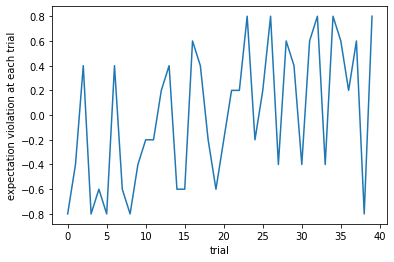

In [6]:
sns.lineplot(data=trials.exp_violation, legend=False).set(xlabel="trial", ylabel="expectation violation at each trial")

In [7]:
# trial-to-trial change in expectation violation
exp_violation_gradient = trials.exp_violation.diff()

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'change in expectation violation')]

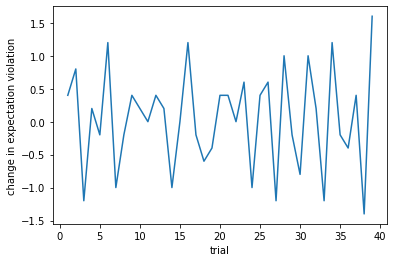

In [8]:
sns.lineplot(data=exp_violation_gradient, legend=False).set(xlabel="trial", ylabel="change in expectation violation")

In [13]:
trials.exp_violation.cumsum().head()

0   -0.8
1   -1.2
2   -0.8
3   -1.6
4   -2.2
Name: exp_violation, dtype: float64

[Text(0.5, 0, 'trial'),
 Text(0, 0.5, 'cumulative range in expectation violation')]

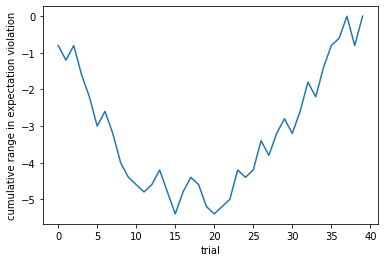

In [14]:
# cumulative sum of expectation violation over trials
sns.lineplot(data=trials.exp_violation.cumsum(), legend=False).set(xlabel="trial", ylabel="cumulative range in expectation violation")

In [ ]:
exp_violation_gradient.min()

In [ ]:
exp_violation_gradient.mean()

In [ ]:
exp_violation_gradient.std()

In [56]:
# masks for each level of expectation violation
mask_min08 = trials[trials.exp_violation == '-0.8'].index.tolist()
mask_min06 = trials[trials.exp_violation == '-0.6'].index.tolist()
mask_min04 = trials[trials.exp_violation == '-0.4'].index.tolist()
mask_min02 = trials[trials.exp_violation == '-0.2'].index.tolist()

mask_08 = trials[trials.exp_violation == '0.8'].index.tolist()
mask_06 = trials[trials.exp_violation == '0.6'].index.tolist()
mask_04 = trials[trials.exp_violation == '0.4'].index.tolist()
mask_02 = trials[trials.exp_violation == '0.2'].index.tolist()

masks = [mask_min08, mask_min06, mask_min04, mask_min02, mask_02, mask_04, mask_06, mask_08]

In [57]:
# get indexes of trials by # red cards = states
for i in set(trials.n_red):
    idxs = trials[trials.n_red == i].index.tolist()
    print("#red cards:", i, "at", idxs)

#red cards: 1 at [0, 3, 5, 8, 12, 21, 22, 25, 36, 38]
#red cards: 2 at [2, 4, 6, 7, 13, 14, 15, 17, 19, 29]
#red cards: 3 at [1, 9, 16, 27, 28, 30, 31, 33, 35, 37]
#red cards: 4 at [10, 11, 18, 20, 23, 24, 26, 32, 34, 39]


## get pilot data

In [15]:
# pilot uuids
uuids = ['5fe200ac3803bbcff9845530', 
         '5ff5c230bce45b062a2a06b2', 
         '5f1b05a8703c380d1393bb27', 
         '5b424267e8815c0001777d94', 
         '604294f7bacd9a1a46cf4da5']

In [16]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

# Use a service account
cred = credentials.Certificate('D:/Behavioural cybersecurity/project-notes/cards-dd-game-61b9b7f26a6e.json')
firebase_admin.initialize_app(cred)

db = firestore.client()

subjects_ref = db.collection(u'subjects')

In [17]:
# responses query reference
refs = []
for uuid in uuids:
    refs.append(subjects_ref.document(uuid).collection(u'responses').document('main_responses').get())

In [18]:
# demographics survey query reference
refs_demographics = []
for uuid in uuids:
    refs_demographics.append(subjects_ref.document(uuid).collection(u'responses').document('demographics').get())

In [19]:
# card values
transdict = {'blue': 1, 'red': -1}

In [20]:
# result values
results_transdict = {'tie': 0, 'loss': -1, 'win': 1}

## PREPROCEESING: convert queried data to workable data model

In [21]:
class GameResponses(object):
    def __init__(self, randomPick, randomPickColour, reportColour, RTreport, honestyRating, RThonesty,
                 results, catchRating, RTcatch):
        self.randomPick = randomPick
        self.randomPickColour = randomPickColour
        self.reportColour = reportColour
        self.honestyRating = honestyRating
        self.catchRating = catchRating
        self.RThonesty = RThonesty
        self.RTreport = RTreport
        self.RTcatch = RTcatch
        self.results = results

    @staticmethod
    def from_dict(source):
        gresponse = GameResponses(source[u'randomPick'], source[u'randomPickColour'], source[u'reportColour'],
                                  source[u'RTreport'], source[u'honestyRating'], source[u'RThonesty'], 
                                  source[u'results'], source[u'catchRating'], source[u'RTcatch'])

        return gresponse

    def to_dict(self):
        dest = {
            u'randomPick': self.randomPick,
            u'randomPickColour': self.randomPickColour,
            u'reportColour': self.reportColour,
            u'RTreport': self.RTreport,
            u'honestyRating': self.honestyRating,
            u'RThonesty': self.RThonesty,
            u'results': self.results,
            u'catchRating': self.catchRating,
            u'RTcatch': self.catch
        }

        return dest

In [22]:
class Demographics(object):
    def __init__(self, age, catch, edlev, gender, twin):
        self.age = age
        self.catch = catch
        self.edlev = edlev
        self.gender = gender
        self.twin = twin

    @staticmethod
    def from_dict(source):
        demos = Demographics(source[u'age'], source[u'catch'], source[u'edlev'],
                                  source[u'gender'], source[u'twin'])

        return demos

    def to_dict(self):
        dest = {
            u'age': self.age,
            u'catch': self.catch,
            u'edlev': self.edlev,
            u'gender': self.gender,
            u'twin': self.twin
        }

        return dest

In [23]:
# main game response data
honestyRatings = []
reportHonesty = []
gameResults = []
transGameResults = []
RThonesty = []
RTreport = []

for subject in refs:
    responses = GameResponses.from_dict(subject.to_dict())
    
    ratings = [int(numeric_string) for numeric_string in responses.honestyRating]
    honestyRatings.append(ratings)
    
    ifLied = np.array([transdict[x] for x in responses.randomPickColour]) == responses.reportColour
    reportHonesty.append(ifLied)
    
    gameResults.append(responses.results)
    
    transResults = np.array([results_transdict[x] for x in responses.results]) 
    transGameResults.append(transResults)
    
    RThonesty.append(responses.RThonesty)
    RTreport.append(responses.RTreport)

In [62]:
normalized_honesty_ratings = []

for ratings in honestyRatings:
#     normed = [(v-min(ratings))/(max(ratings)-min(ratings)) for v in ratings]
    normed = [(v/6) for v in ratings]
    normalized_honesty_ratings.append(normed)

In [27]:
# correct RT report cumulative values
rtreport0_tmp = pd.Series(RTreport[0]).diff().fillna(RTreport[0][0])

In [51]:
# reverse-code honesty ratings to reflect suspicion
import numexpr
suspicionRating = numexpr.evaluate('(6 - honestyRatings)')

In [101]:
normalized_suspicion_ratings = numexpr.evaluate('(1 - normalized_honesty_ratings)')

In [102]:
normalized_suspicion_ratings

array([[0.83333333, 0.33333333, 0.33333333, 0.83333333, 0.        ,
        0.83333333, 0.5       , 0.5       , 1.        , 0.5       ,
        0.33333333, 0.33333333, 0.5       , 0.66666667, 0.33333333,
        0.66666667, 0.33333333, 0.5       , 0.16666667, 0.66666667,
        0.33333333, 0.16666667, 0.16666667, 1.        , 0.16666667,
        0.33333333, 0.33333333, 0.33333333, 0.66666667, 0.5       ,
        0.33333333, 0.33333333, 1.        , 0.5       , 0.5       ,
        0.33333333, 0.33333333, 0.66666667, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.66666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.        , 0.16666667, 0.66666667, 0.66666667, 0.33333333,
        0.33333333, 0.33333333, 0.66666667, 0.83333333, 0.16666667,
        0.16666667, 0.66666667, 0.33333333, 0.83333333, 0.83333333,
        0.66666667, 0.83333333, 0.83333333, 0.6

In [ ]:
# demographics data
edlev = []
catch = []

for subject in refs_demographics:
    demos = Demographics.from_dict(subject.to_dict())
    edlev.append(demos.edlev)
    catch.append(demos.catch)

In [ ]:
catch

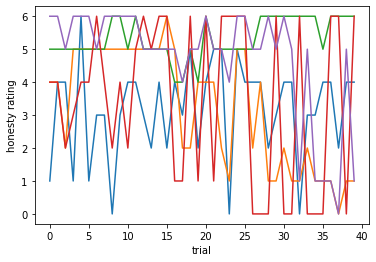

In [25]:
for i in range(len(honestyRatings)):
    sns.lineplot(data=honestyRatings[i], legend=False).set(xlabel="trial", ylabel="honesty rating")

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'game result')]

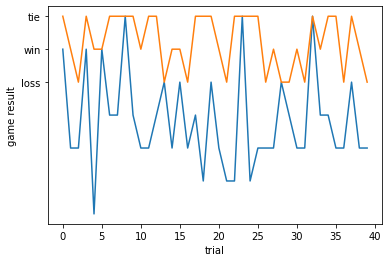

In [26]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=gameResults[0], legend=False).set(xlabel="trial", ylabel="game result")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=trials.exp_violation, legend=False).set(xlabel="trial", ylabel="expectation violation")

In [ ]:
ev_tmp = exp_violation_gradient.cumsum().fillna(0)

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=ev_tmp, legend=False).set(xlabel="trial", ylabel="cumulative expectation violation")

In [ ]:
# subject that lied most
sns.lineplot(data=honestyRatings[0], legend=False)
sns.lineplot(data=exp_violation_gradient, legend=False).set(xlabel="trial", ylabel="change in expectation violation")

In [ ]:
# subject that lied least
sns.lineplot(data=honestyRatings[2], legend=True)
sns.lineplot(data=gameResults[2], legend=True).set(xlabel="trial", ylabel="game result")

### parameter estimation - grid search

In [71]:
from specs import *

In [92]:
from itertools import product

# parameter search space
alpha = np.linspace(0,1,11)
beta = np.linspace(-10,20,31)
params = tuple(product(alpha, beta))

trials = []
for trial in trials_source:
    trials.append(Trial(n_red=trial['n_red'], outcome=trial['outcome']))

x0 = [0.2, 1] # starting point (guess)

In [156]:
def param_recovery_proba(x, params):
    for param in params:
        player = Player(alpha=param[0], beta=param[1])
        g = Game(trials, player)
        g.simulate(verbose=False)
        ps = np.array(g.softmax_probabilities)
        sse.append(sum((x-ps)**2))
    minimum_idx = np.where(sse == np.amin(sse))[0]
    print("SSE minimum index:", minimum_idx)
    print("BEST PARAMETER ESTIMATES:", params[minimum_idx[0]])

In [178]:
sse = []
param_recovery_proba(normalized_suspicion_ratings[0], params)

starting game play simulation
player attributes: bias:  0 alpha:  0.0 beta: -10.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a t

number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.0 beta: -5.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobod

trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.0 beta: -1.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8


player attributes: bias:  0 alpha:  0.0 beta: 5.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or lose

trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a poin

trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials wi

number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or lose

number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins o

number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 

trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a 

trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  21
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  22
You lose 1 point
You win 1 point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 poin

trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose

number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 

trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  21
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nob

trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.2 beta: 2.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 

trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobo

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 po

trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of tria

trial:  39
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.30000000000000004 beta: -10.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or los

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given

trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 1 point


trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  20
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of tria

trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_r

You lose 1 point
You win 1 point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins o

trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.30000000000000004 beta: 18.0
trial:  1
You win 1 point
You lose

You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.4 beta: -8.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lo

trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.4 beta: -5.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of t

number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.4 beta: 1.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a poi

trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_r

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or

number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with give

trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.5 beta: 4.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 

trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
You lose 1 poin

trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.5 beta: 15.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of tria

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.5 beta: 18.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You wi

number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with give

It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.6000000000000001 beta: -6.0
trial:  1
You win 1 point
You lose 1 p

You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1

You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie:

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
You win 1 point
You lose 

You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attribu

player attributes: bias:  0 alpha:  0.6000000000000001 beta: 12.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  5
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win

trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials 

It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
You lose 1 point
You win 1 point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
n

number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial

trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of tri

trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_r

It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials 

You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  33
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
You lose 1 point
You win 1 point
number of trials with given n_red: 9
tria

You win 1 point
number of trials with given n_red: 8
trial:  19
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of 

trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  1

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given 

trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
You win 1 point
You lose 1 point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play

trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  37
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_

number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  25
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  26
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  27
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
You lose 1 point
You win 1 point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobod

trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  25
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  26
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
It's a tie: nobody wins or loses a point
It's a tie: nobody win

trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.8 beta: 20.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
You lose 1 point
You win 1 point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of tr

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials with given n

trial:  27
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  28
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  29
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
You lose 1 poi

trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  15
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
numb

trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  0.9 beta: 7.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  8
You win 1 point
Y

trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  13
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
You win 1 point
You lose 1 point
number of trials with given n_red: 7
trial:  17
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  19
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  20
You win 1 point
You lose 1 point
number of trials with given n_red: 9
trial:  21
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  22
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  23
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  24
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with giv

You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  11
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  12
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 2
trial:  13
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  14
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  15
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  16
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 7
trial:  17
You lose 1 point
You win 1 point
number of trials with given n_red: 3
trial:  18
It's a tie: nobody wins or loses a point
I

starting game play simulation
player attributes: bias:  0 alpha:  1.0 beta: 0.0
trial:  1
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point
You lose 1 point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 

number of trials with given n_red: 8
trial:  27
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  28
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  29
You lose 1 point
You win 1 point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a

It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 5
trial:  30
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  31
You win 1 point
You lose 1 point
number of trials with given n_red: 6
trial:  32
You lose 1 point
You win 1 point
number of trials with given n_red: 7
trial:  33
You lose 1 point
You win 1 point
number of trials with given n_red: 8
trial:  34
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 8
trial:  35
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  36
You lose 1 point
You win 1 point
number of trials with given n_red: 9
trial:  37
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
You lose 1 point
You win 1 point
number of trials with given n_red: 10
tri

It's a tie: nobody wins or loses a point
number of trials with given n_red: 9
trial:  38
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 10
trial:  39
You win 1 point
You lose 1 point
number of trials with given n_red: 10
trial:  40
You lose 1 point
You win 1 point
number of trials with given n_red: 10
end of simulated game
starting game play simulation
player attributes: bias:  0 alpha:  1.0 beta: 16.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
You win 1 point


In [179]:
tmp = Game(trials, Player(alpha=params[39][0], beta=params[39][1]))
tmp.simulate(verbose=False)

starting game play simulation
player attributes: bias:  0 alpha:  0.1 beta: -2.0
trial:  1
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  2
You win 1 point
You lose 1 point
number of trials with given n_red: 1
trial:  3
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 1
trial:  4
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  5
You win 1 point
You lose 1 point
number of trials with given n_red: 2
trial:  6
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  7
It's a tie: nobody wins or loses a point
It's a tie: nobody wins or loses a point
number of trials with given n_red: 3
trial:  8
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  9
You win 1 point
You lose 1 point
number of trials with given n_red: 4
trial:  10
It's a tie: nobody wins or loses a point


In [180]:
ddf = pd.DataFrame(tmp.softmax_probabilities)

In [181]:
ddf['label'] = "estimated"

In [182]:
ddf.head()

,0,label
0,1.000000,estimated
1,1.000000,estimated
2,1.000000,estimated
3,0.539915,estimated
4,0.569546,estimated


In [183]:
dddf = pd.DataFrame(normalized_suspicion_ratings[0])

In [184]:
dddf['label'] = "actual"

In [185]:
tmp = pd.concat([ddf, dddf])
tmp.columns = ["probability", "label"]

[Text(0.5, 0, 'trial'), Text(0, 0.5, 'p(deception)')]

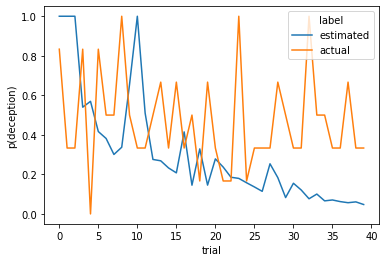

In [186]:
sns.lineplot(data=tmp, x=tmp.index, y='probability', hue='label').set(xlabel="trial", ylabel="p(deception)")

### TRY: log transform honesty ratings

In [168]:
tmp_log_suspicionrating = [np.log(v+1) for v in suspicionRating[4]]

In [174]:
spearmanr(tmp_log_suspicionrating, tmp.softmax_probabilities)

SpearmanrResult(correlation=0.12283134142916553, pvalue=0.4501975172058572)

## aggregated analyses across participants

In [172]:
from scipy.stats import pearsonr

In [173]:
from scipy.stats import spearmanr

In [ ]:
spearmanr(rtreport0_tmp, honestyRatings[0])

In [59]:
# average honesty rating and SD
avgHonestyRatings = []
sdHonestyRatings = []

for index, ratings in enumerate(honestyRatings):
#     print(index, ratings)
    ratingsInt = [int(numeric_string) for numeric_string in ratings]
    mean = sum(ratingsInt)/len(ratingsInt)
    avgHonestyRatings.append(mean)
    sd = np.std(ratingsInt)
    sdHonestyRatings.append(sd)
    print("average honesty rating", mean, "std", sd)

average honesty rating 3.175 std 1.4471955638406304
average honesty rating 3.225 std 1.7956544767855536
average honesty rating 5.325 std 0.6077622890571609
average honesty rating 3.425 std 2.4585310654941908
average honesty rating 4.7 std 1.7204650534085253


In [ ]:
avgHonestyRatings

In [ ]:
sdHonestyRatings

In [ ]:
propLied = []

for index, report in enumerate(reportHonesty):
#     print(index, report)
    lieProportion = (len(report) - sum(report)) / len(report)
    print(lieProportion)
    propLied.append(lieProportion)

In [ ]:
# aggregate pearson's correlation proportion the participant lied and average honesty rating
pearsonr(propLied, avgHonestyRatings)

In [ ]:
spearmanr(propLied, avgHonestyRatings)

In [ ]:
# aggregate game results per participant
wins = []
losses = []
ties = []

for result in gameResults:
    unique, counts = np.unique(result, return_counts=True)
    outcome = dict(zip(unique, counts))
    wins.append(outcome['win'])
    losses.append(outcome['loss'])
    ties.append(outcome['tie'])
#     print(outcome)

In [ ]:
# aggregate spearman's correlation game results (win/loss/tie) & average honesty rating
spearmanr(avgHonestyRatings, wins)
spearmanr(avgHonestyRatings, losses)
spearmanr(avgHonestyRatings, ties)

# no correlation at all between game outcome and honesty rating

In [ ]:
# rank-based spearman's correlation game results (win/loss/tie) & honesty rating
for i in range(len(RThonesty)):
    cor = spearmanr(transGameResults[i], honestyRatings[i])
    print(cor)

In [ ]:
# rank-based spearman's correlation game results (win/loss/tie) & RT honesty rating
for i in range(len(RThonesty)):
    cor = spearmanr(transGameResults[i], RThonesty[i])
    print(cor)

In [ ]:
# get individual correlates level of expectation violation

for i in range(len(uuids)):
    for index, mask in enumerate(masks):
        print("=" * 50)
        print("participant", i)
        print(transGameResults[i][mask])
        print(np.array(RThonesty[i])[mask])
        pcorr = pearsonr(transGameResults[i][mask], np.array(RThonesty[i])[mask])
        scorr = spearmanr(transGameResults[i][mask], np.array(RThonesty[i])[mask])
        print(index, "pearson's r", pcorr)
        print(index, "spearman's r", scorr)

In [ ]:
# get individual correlates level of expectation violation

for i in range(len(uuids)):
    for index, mask in enumerate(masks):
        print("=" * 50)
        print("participant", i)
        rating = np.array(honestyRatings[i])[mask]
        RT = np.array(RThonesty[i])[mask]
        print(rating)
        print(RT)
        pcorr = pearsonr(rating, RT)
        scorr = spearmanr(rating, RT)
        print(index, "pearson's r", pcorr)
        print(index, "spearman's r", scorr)

In [ ]:
# correlate how much participant lied per level with average honesty rating for each level of expectation violation
# i.e. r(lied, honestyrating) | exp_violation

avg_rating = []
avg_prop_lie = []

for index, mask in enumerate(masks):
    for i in range(len(uuids)):      
        rating = np.array(honestyRatings[i])[mask]
        lied = np.array(reportHonesty[i])[mask]
        
        mean_rating = sum(rating)/len(rating)
        n_lied = (len(lied)-sum(lied))/len(lied)
        
        avg_rating.append(mean_rating)
        avg_prop_lie.append(n_lied)
#         print("=" * 50)
#         print("participant", i)
#         print(rating)
#         print(lied)
#         print(mean_rating)
#         print(n_lied)

In [ ]:
spearmanr(avg_rating[0:4], avg_prop_lie[0:4])

In [ ]:
spearmanr(avg_rating[5:9], avg_prop_lie[5:9])

In [ ]:
spearmanr(avg_rating[10:14], avg_prop_lie[10:14])

In [ ]:
spearmanr(avg_rating[15:19], avg_prop_lie[15:19])

In [ ]:
spearmanr(avg_rating[20:24], avg_prop_lie[20:24])

In [ ]:
spearmanr(avg_rating[25:29], avg_prop_lie[25:29])

In [ ]:
spearmanr(avg_rating[30:34], avg_prop_lie[30:34])

In [ ]:
spearmanr(avg_rating[35:39], avg_prop_lie[35:39])

In [ ]:
# inspect correlation  between exp_violation and avg_prop_lie


In [ ]:
# logistic regression or nlme for honestyrating <- result; lying <- result
